# Linear Second-Order Poisson Equation

### Formulation:

$L[u(x)] = f(x) \qquad x \in [0,10]$

$[-p(x) u_x(x)]_x = f(x)$

$p(x) = v_a(x) * p_a + v_b(x) * p_b \qquad p_a = 12, p_b = 3$

$v_a(x) = 1- v_b(x)$

$v_b(x) = (v_b(0)-v_b(10))*e^{0.4x} + v_b(10)$

Where the $v_a$ and $v_b$ are spatially varying volymetric fractions of components $a$ and $b$ respectively. The volumetric fraction of component $b$ varies following an exponential trend in the domain $x\in[0,10]$.

### Forcing Library
I = {0.2, 0.3, 0.4, 0.5, 0.6}

J = {1, 3, 5, 7, 9}

K = {0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3}

F = {$f_j(i_a, j_b, k_c): i_a*sin(j_b*x)+k_c), i_a*cos(j_b*x+0.5)+k_c)$}, $\; \forall \; i_a \in I, j_b \in J, k_c \in K$


In [1]:
%load_ext autoreload
%autoreload 2

# Python imports
import pickle

# Third-Party Imports
import numpy as np
from numpy import sin, cos
import matplotlib.pyplot as plt

# Package Imports
from sindy_bvp.bvp_solver import IVPSolver, BVPShooter, sturm_liouville_function, get_forcings

In [2]:
class ExponentialDecayProperty:
    def __init__(self, min_b_frac, max_b_frac, decay_const, a_val, b_val):
        self.min_b_frac = min_b_frac
        self.max_b_frac = max_b_frac
        self.decay_const = decay_const
        self.a_val = a_val
        self.b_val = b_val
        
    def p(self, x):
        b_frac = (self.max_b_frac-self.min_b_frac)*np.exp(-self.decay_const*x)+self.min_b_frac
        p = (1-b_frac) * self.a_val + b_frac * self.b_val
        return p
    
    def p_x(self, x):
        p_x = (self.b_val - self.a_val)*(self.max_b_frac-self.min_b_frac)*(-self.decay_const)*np.exp(-self.decay_const*x)
        return p_x


In [3]:
## Set file name to save with
save_stem = "./data/S3-P2-"

####################################
## SET UP x, p(x), q(x), and f(x) ##
####################################

# Define the independent variable bounds and discrete increments
x_min = 0.0; x_max = 10; dx = 0.01;
x_array = np.linspace(x_min, x_max, int((x_max-x_min)/dx)+1)

# Define the parameters for the exponential decay model
edp = ExponentialDecayProperty(min_b_frac=0.1, max_b_frac=0.8, decay_const=0.4, a_val=12, b_val=3)
# success with aval=4, bval=1... but order of soln around 3-6 instead of O(1)

# Define the parameters of the S-L IVP
p = lambda x, edp=edp: edp.p(x)
p_x = lambda x, edp=edp: edp.p_x(x)
q = lambda x: 0

# Get forcings
i_set = np.arange(0.2,0.7,0.1)
j_set = np.arange(1,10,2)
k_set = np.arange(0.7,1.3,0.1)
forcings = get_forcings(i_set=i_set, j_set=j_set, k_set=k_set)

# Specify initial values to start with for solving S-L BVPs via shooting method
ic = [0.8,0.5] # Selected 0.5 as initial du/dx since solutions are order(1)

print("Forcing library contains",len(forcings), "functions.")
print(i_set,'\n',j_set,'\n',k_set,'\n',)

Forcing library contains 350 functions.
[0.2 0.3 0.4 0.5 0.6] 
 [1 3 5 7 9] 
 [0.7 0.8 0.9 1.  1.1 1.2 1.3] 



In [4]:
%%time

#####################################################
## Solve the Sturm-Liouville Differential Equation ##
#####################################################

# Prepare the BVP shooting method
bvp_solver = BVPShooter(IVPSolver(t_min=x_min, t_max=x_max, dt=dx), 
                        ic_index = 1,
                        attempts = 50,
                        bv_tolerance = 0.001)

# Create function(x,y,f) for the differential equation, specifying p(x), p_x(x), and q(x)
sl_func = lambda x, y, f: sturm_liouville_function(x, y, p=p(x), p_x = p_x(x), q=q(x), f=f)


# Use the shooting method to generate the solutions
ode_sols, used_fs = bvp_solver.generate_multiple_experiments(diffeq = sl_func, 
                                                             forcings = forcings, 
                                                             init_vals_list = [ic], 
                                                             verbose=True)

0 status = complete, 2 status = failed to converge
Solution statuses: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 
Created 326 solutions.
CPU times: user 3min 40s, sys: 628 ms, total: 3min 40s
Wall time: 3min 40s


In [5]:
#####################
## Pickle the data ##
#####################
# Pickle the x array
pickle.dump(x_array, open(save_stem+"x.pickle", "wb"))

# Pickle the solutions
pickle.dump(ode_sols, open(save_stem+"sols.pickle", "wb"))

# Vectorize the forcing functions and pickle the forcing vectors
forcings = [f(x_array) for f in used_fs]
pickle.dump(forcings, open(save_stem+"fs.pickle", "wb"))

# Vectorize, organize, and pickle the Sturm-Liouville coefficients
coeffs = { 'p': np.vectorize(p)(x_array),
           'p_x': np.vectorize(p_x)(x_array),
           'q': np.zeros(x_array.shape)}
pickle.dump(coeffs, open(save_stem+"coeffs.pickle", "wb"))

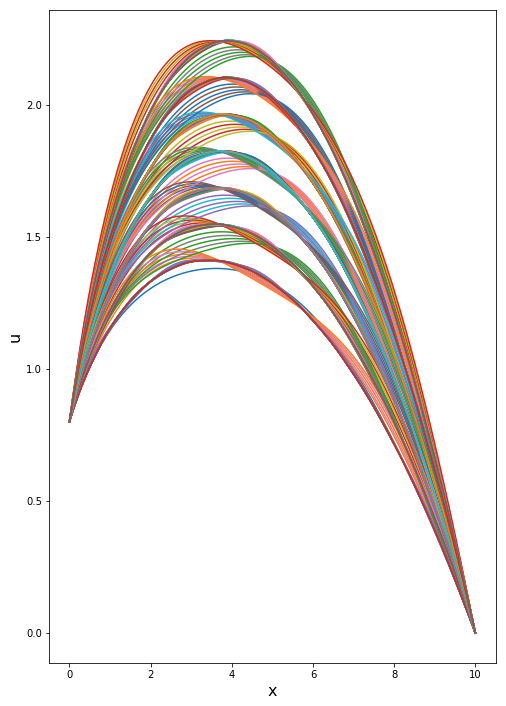

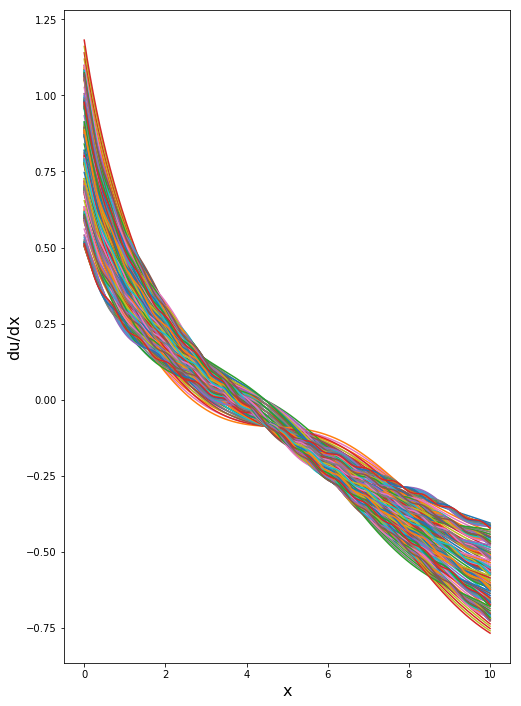

In [6]:
#############################
## Show the generated data ##
#############################

plt.figure(figsize=(8,12))
for sol in ode_sols:
    plt.plot(sol.t, sol.y[0]) # u vs x
plt.ylabel("u", fontsize=16)
plt.xlabel("x", fontsize=16)


plt.figure(figsize=(8,12))
for sol in ode_sols:
    plt.plot(sol.t, sol.y[1]) # du/dx vs x
plt.ylabel("du/dx", fontsize=16)
plt.xlabel("x", fontsize=16)


plt.show()

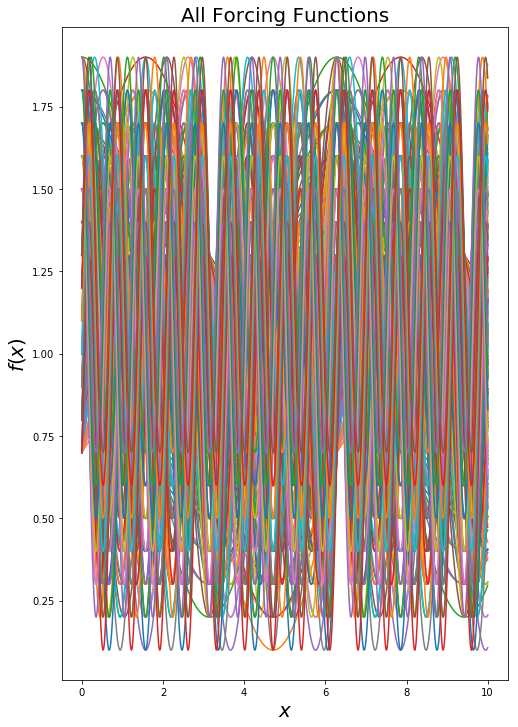

In [7]:
# And forcings
plt.figure(figsize=(8,12))
for f in forcings:
    plt.plot(x_array, f) # du/dx vs x
fs = 20
plt.title("All Forcing Functions", fontsize=fs)
plt.ylabel("$f(x)$", fontsize=fs)
plt.xlabel("$x$", fontsize=fs)
plt.show()